# Stimare Q function ottimale
## 1. Quanto tempo ci mette per convergere a Q*, al variare di tau
## 2. Distanza tra Q* e Q_t 
## 3. distanza tra Q_0 e Q_0 appresa tramite i valori di tau
## 4. cercare di integrare i bound trovati

### Estrarre policy da Q
### Confrontare due diverse Q valutando diverse metriche 
### Calcolare Q*
### Tentativo di implementazione di un curriculum
### Plot functions

In [1]:
import numpy as np
from TMDP import TMDP
from river_swim import River

from algorithms import *
import matplotlib as mpl
import matplotlib.pyplot as plt

np.set_printoptions(precision=3)
import math

In [2]:
# Test with tau=0.9
nS = 8
gamma = 0.9
river = River(nS, gamma, 5, 1000)
tau = 0.9
xi = np.ones(river.nS)*1/river.nS
tmdp = TMDP(river, xi, tau, gamma)

In [3]:
results = []

r_s_a = compute_r_s_a(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward)
Q_star = bellman_optimal_q(tmdp.nS, tmdp.nA, tmdp.P_mat, tmdp.reward, 1e-4, gamma)
J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat, get_policy(Q_star), tmdp.reward, tmdp.gamma, tmdp.mu)
delta_q = np.linalg.norm(Q_star - Q_star, np.inf)
print(delta_q)
results.append({"type":"Bellman", "Q": Q_star, "tau":"/", "J":J, "policy":get_policy(Q_star), "delta_q":delta_q})
print(results)

0.0
[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': 365.78861003317843, 'policy': [1, 1, 1, 1, 1, 1, 1, 1], 'delta_q': 0.0}]


In [4]:

""" xi = np.ones(river.nS)*1/river.nS
gamma = 0.9
river = River(gamma)

for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    s = tmdp.reset()
    M = 10000
    Q = np.zeros((tmdp.nS, tmdp.nA))
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
    Qs.append({"tau":tau, "Q_function":Q, "env":tmdp})

for i in range(len(taus)):
    print("Tau:", Qs[i]['tau'])
    print(Qs[i]['Q_function']) """

' xi = np.ones(river.nS)*1/river.nS\ngamma = 0.9\nriver = River(gamma)\n\nfor tau in taus:\n    tmdp = TMDP(river, xi, tau, gamma)\n    s = tmdp.reset()\n    M = 10000\n    Q = np.zeros((tmdp.nS, tmdp.nA))\n    ret = 0\n    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])\n    Q = Q_learning(tmdp, s, a, Q, M)\n    Qs.append({"tau":tau, "Q_function":Q, "env":tmdp})\n\nfor i in range(len(taus)):\n    print("Tau:", Qs[i][\'tau\'])\n    print(Qs[i][\'Q_function\']) '

In [5]:
""" pi = get_policy(Qs[-2]['Q_function'])
pi_prime = get_policy(Qs[-1]['Q_function'])

print(pi)
print(pi_prime) """

" pi = get_policy(Qs[-2]['Q_function'])\npi_prime = get_policy(Qs[-1]['Q_function'])\n\nprint(pi)\nprint(pi_prime) "

In [6]:

taus = [1 - i*0.1 for i in range(10)]
Q = np.zeros((tmdp.nS, tmdp.nA))
# Curriculul for decreasing values of tau
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    M = 10000
    if tau == 0:
       M=100000
       print("here")
    
    s = tmdp.reset()
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
delta_q = np.linalg.norm(Q_star - Q, np.inf)
J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
results.append({"type":"curriculum", "Q": Q, "tau":"1 -> 0", "J":J, "policy":get_policy(Q), "delta_q":delta_q})



In [7]:
# Learning from scratch with different values of tau
taus.append(0)
for tau in taus:
    tmdp = TMDP(river, xi, tau, gamma)
    Q = np.zeros((tmdp.nS, tmdp.nA))
    
    s = tmdp.reset()
    M = 10000
    ret = 0
    a = eps_greedy(s, Q, 1., tmdp.allowed_actions[s.item()])
    Q = Q_learning(tmdp, s, a, Q, M)
    print(get_policy(Q, False))
    delta_q = np.linalg.norm(Q_star - Q, np.inf)
    J = get_expected_avg_reward(tmdp.nS, tmdp.nA, tmdp.P_mat_tau, get_policy(Q), tmdp.reward, tmdp.gamma, tmdp.mu)
    results.append({"type":"scratch", "Q": Q, "tau":"{:.1f}".format(tau), "J":J, "policy":get_policy(Q),"delta_q":delta_q})

[[1.273e-28 1.000e+00]
 [5.748e-26 1.000e+00]
 [1.000e+00 1.033e-27]
 [3.379e-23 1.000e+00]
 [1.360e-19 1.000e+00]
 [1.000e+00 1.234e-29]
 [8.406e-23 1.000e+00]
 [9.405e-72 1.000e+00]]
[[1.000e+00 6.588e-15]
 [5.433e-14 1.000e+00]
 [6.841e-18 1.000e+00]
 [1.000e+00 4.075e-09]
 [1.000e+00 5.006e-17]
 [1.000e+00 1.012e-16]
 [7.606e-19 1.000e+00]
 [1.397e-79 1.000e+00]]
[[1.000e+000 2.961e-035]
 [1.000e+000 6.098e-046]
 [1.000e+000 3.371e-039]
 [1.000e+000 1.841e-031]
 [1.000e+000 5.456e-025]
 [1.000e+000 5.761e-010]
 [1.000e+000 1.142e-027]
 [2.396e-111 1.000e+000]]
[[1.000e+000 7.088e-044]
 [1.000e+000 9.635e-049]
 [7.163e-036 1.000e+000]
 [3.491e-050 1.000e+000]
 [1.000e+000 8.242e-046]
 [1.685e-046 1.000e+000]
 [1.135e-043 1.000e+000]
 [7.510e-135 1.000e+000]]
[[1.000e+000 3.112e-042]
 [1.000e+000 4.320e-051]
 [5.176e-044 1.000e+000]
 [1.000e+000 1.167e-044]
 [3.757e-026 1.000e+000]
 [1.000e+000 8.413e-057]
 [7.320e-080 1.000e+000]
 [7.802e-130 1.000e+000]]
[[1.448e-014 1.000e+000]
 [

In [8]:
print(results)

[{'type': 'Bellman', 'Q': array([[ 68.054,  70.06 ],
       [ 63.054,  96.009],
       [ 86.408, 140.217],
       [126.195, 206.885],
       [186.197, 305.732],
       [275.159, 451.916],
       [406.724, 668.02 ],
       [601.218, 987.469]]), 'tau': '/', 'J': 365.78861003317843, 'policy': [1, 1, 1, 1, 1, 1, 1, 1], 'delta_q': 0.0}, {'type': 'curriculum', 'Q': array([[ 73.797,  86.932],
       [ 82.731,  70.933],
       [ 87.27 ,  61.075],
       [ 91.119,  54.496],
       [ 90.55 ,  54.113],
       [ 55.079, 197.212],
       [ 84.91 , 300.709],
       [128.257, 495.987]]), 'tau': '1 -> 0', 'J': 246.48188362430128, 'policy': [1, 0, 0, 0, 0, 1, 1, 1], 'delta_q': 964.4425310659058}, {'type': 'scratch', 'Q': array([[ 57.924, 122.155],
       [ 67.862, 125.981],
       [137.312,  75.174],
       [ 82.1  , 133.842],
       [ 87.448, 130.889],
       [121.099,  54.534],
       [ 67.988, 118.818],
       [ 65.799, 229.343]]), 'tau': '1.0', 'J': 156.2500000000001, 'policy': [1, 1, 0, 1, 1, 0, 1

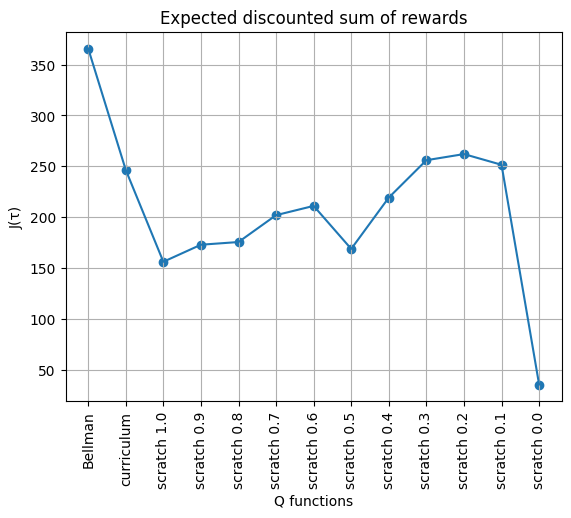

In [15]:
x = []
y = []
for res in results:
    x.append(res['J'])
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("J(τ)")
plt.title("Expected discounted sum of rewards")
plt.grid(visible=True)




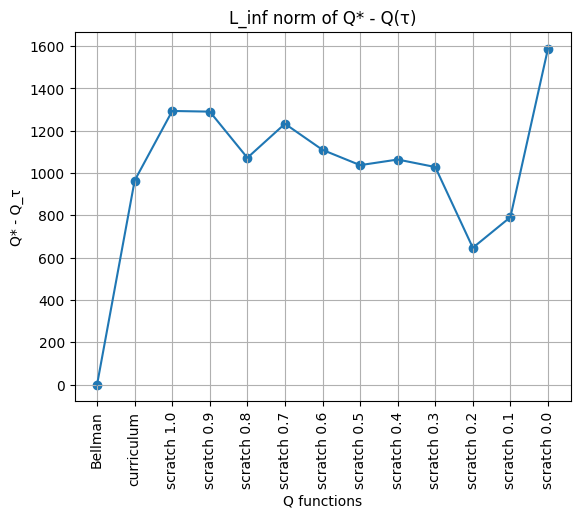

In [14]:
x = []
y = []
for res in results:
    delta_q = np.linalg.norm(results[0]['Q'] - res['Q'], np.inf)
    x.append(delta_q)
    label = res['type'] + " " + str(res['tau']) if res['type'] == 'scratch' else res['type']
    y.append(label)

#fig, ax = plt.subplots(figsize=(5, 2.7), layout='constrained')
plt.scatter(y, x)
plt.plot(y, x)
plt.xlabel("Q functions")
plt.xticks(rotation=90)
plt.ylabel("Q* - Q_τ")
plt.title("L_inf norm of Q* - Q(τ)")
plt.grid(visible=True)